In [55]:
%matplotlib inline

import numpy as np
import math
from scipy.integrate import quad
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from functools import reduce

# ノンパラメトリックベイズモデル入門からクラスタリングへの応用

scikit learnのGaussian Mixture Modelの解説ページ  
http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#example-mixture-plot-gmm-py  
Dirichlet Distributions with Matplotlib  
http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/  
東京で働くデータサイエンティストのブログ：パッケージユーザーのための機械学習(9)：混合ディリクレ過程
http://tjo.hatenablog.com/entry/2014/06/12/190319

## 0 導入

### 0.1 クラスタリングと混合ガウス分布

K-平均アルゴリズムとは以下の最適化問題を解くことである.  
$$(z^*_{1:n}, \mu^*_{1:K})=arg min_{z_{1:n}, \mu_{1:K}}\sum^n_{i=1}\sum^K_{k=1}\delta(z_i = k)||x_i-\mu_k||^2$$  
この目的関数は、  
$$(z^*_{1:n}, \mu^*_{1:K})=arg min_{z_{1:n}, \mu_{1:K}}log\Pi^n_{i=1}N(x_i|\mu_{z_i},I)$$  
と書き換えることができる.

（注）上の変形は、
$$\sum^n_{i=1}\sum^K_{k=1}\delta(z_i = k)||x_i-\mu_k||^2 \\
\propto -\sum^n_{i=1}\sum^K_{k=1}\delta(z_i = k)(-\frac{1}{2}||x_i-\mu_k||^2) \\
= -(nDlog(\sqrt{2\pi}+\sum^n_{i=1}\sum^K_{k=1}\delta(z_i = k)logN(\bf{x}_i|\bf{\mu}_k, \bf{I})) \\
= -(nDlog(\sqrt{2\pi}+log\Pi^n_{i=1}N(\bf{x}_i|\bf{\mu}_{zi},\bf{I}))
$$
による。2段目の変形はlog(Aexp(B))を考えればよい。

In [233]:
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

In [234]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

In [235]:
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

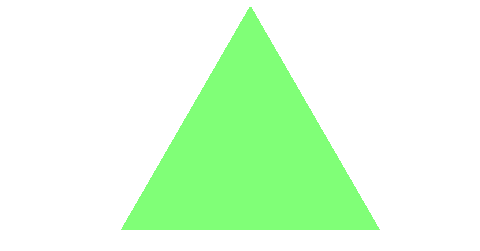

In [240]:
plt.figure(figsize=(8, 4))
draw_pdf_contours(Dirichlet([1, 1, 1]))

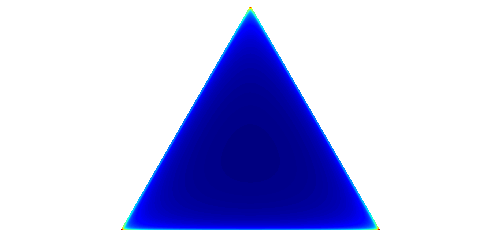

In [244]:
plt.figure(figsize=(8, 4))
draw_pdf_contours(Dirichlet([0.8, 0.8, 0.8]))

混合ガウスモデルの例.  
この[ページ](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#example-mixture-plot-gmm-py)のコードを実行.

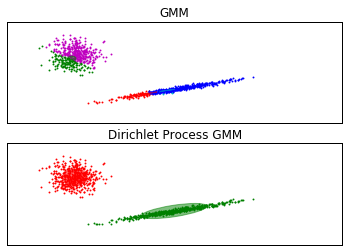

In [56]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a mixture of Gaussians with EM using five components
gmm = mixture.GMM(n_components=5, covariance_type='full')
gmm.fit(X)

# Fit a Dirichlet process mixture of Gaussians using five components
dpgmm = mixture.DPGMM(n_components=5, covariance_type='full')
dpgmm.fit(X)

color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

for i, (clf, title) in enumerate([(gmm, 'GMM'),
                                  (dpgmm, 'Dirichlet Process GMM')]):
    splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-10, 10)
    plt.ylim(-3, 6)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

plt.show()

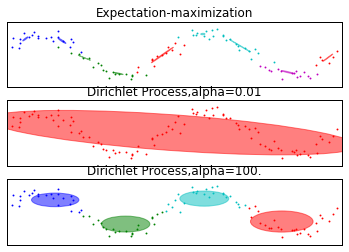

In [9]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
from sklearn.externals.six.moves import xrange

# Number of samples per component
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4 * np.pi / n_samples

for i in xrange(X.shape[0]):
    x = i * step - 6
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3 * (np.sin(x) + np.random.normal(0, .2))


color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])


for i, (clf, title) in enumerate([
        (mixture.GMM(n_components=10, covariance_type='full', n_iter=100),
         "Expectation-maximization"),
        (mixture.DPGMM(n_components=10, covariance_type='full', alpha=0.01,
                       n_iter=100),
         "Dirichlet Process,alpha=0.01"),
        (mixture.DPGMM(n_components=10, covariance_type='diag', alpha=100.,
                       n_iter=100),
         "Dirichlet Process,alpha=100.")]):

    clf.fit(X)
    splot = plt.subplot(3, 1, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6, 4 * np.pi - 6)
    plt.ylim(-5, 5)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

plt.show()

## 1 ディリクレ過程混合モデル

仮定  
$$z_i\sim Multi(\pi)(i=1,...,n), \pi \sim Dir(\alpha), \alpha_k = \alpha/K$$

### 1.1 ディリクレ分布

N次元確率ベクトルの集合を  
$$\triangle^K=Bigl\{\pi = (\pi_1, \pi_2, ..., \pi_K|\sum^K_{k=1}=1, \pi_k≥0 ~~ \forall k$$
とする。ディリクレ分布はこのような$\triangle^K$上の確率分布としてしばしば使われ、その密度関数は、  
$$ Dir(\pi|\alpha)\equiv\frac{\Gamma(\sum^K_{k=1}\alpha_k}{\Pi^K_{k=1}\Gamma(\alpha_k)}\Pi^K_{k=1}\pi^{\alpha_k-1}_k$$

### 1.2 多項分布  

xをK種類の値{1,2,...,K}をとる確率変数とする.  
それぞれの値をとる確率を$\pi=(\pi_a, \pi_2,...,\pi_K)(\sum^K_{k=1}\pi_k =1)$とする.  
n回の独立した試行を考え、$x_i = k$により、i回目の試行における値がkであることを示すとする.  
$n_k$でkという値が出た回数を表現する.  
$\pi$が与えられたもとで、$x_i=k$である確率は$p(x_i=k|\pi)=\pi_k$となる.  
このとき、$\pi$が与えられたもとでの$x={x_1, x_2,...,x_n}$の確率は、  
$$p(x|\pi)=\Pi^n_{i=1}p(x_i|\pi)=\Pi^K_{k=1}\pi^{n_k}_k$$
と計算できる.

各試行における値ではなく、n回の試行における各値の出現回数

### 1.3 ディリクレ分布の性質

$Dir(\pi|\alpha/K)$の二つの性質.  
(1)各kで$\alpha_k$が同じ値であるため、事前分布としてはkに区別はない.  
(2)次元Kが大きくなるにしたがって、ディリクレ分布のパラメータ$\alpha_k$は小さくなる.  

以上の仮定のもと、$z_{1:n}$のサンプリングを考える.  
ただし、$\pi$は$\sum^\infty_{k=1}\pi_k=1$という制約があり、この制約を満たしたままサンプリングを行うことは難しい.  
→周辺化をしてしまえば$\pi$を直接扱う必要はなくなる.  

### 1.4 周辺化

結合分布から特定の変数を積分消去すること.  
(例)$$ p(x_1, x_3) = \int p(x_1, x_2, x_3)dx_2$$  
ベイズ推定では、観測データ$x_{1:n}$の尤度$p(x_{1:n}|\phi)$を事前分布$p(\phi|\eta)$を事前分布$p(\phi|\eta)$で周辺化した  
$$p(x_{1:n}|\eta) = \int p(x_{1:n}|\phi)p(\phi|\eta)d\phi=\int p(x_{1:n}, \phi|\eta)d\phi$$  
を周辺尤度と呼ぶ.

### 1.5 条件付き確率密度関数の計算

$$ p(z_i = k|z^{\backslash i}_{1:n}, \alpha) = \frac{n^{\backslash i}_{k} + \alpha/K}{n-1+\alpha}$$

$$p(z_i = k|z^{\backslash i}_{1:n}, \alpha)=\left\{ \begin{array}{1}
\frac{n^{\backslash i}_{k} + \alpha/K}{n-1+\alpha} & if ~~ k\in K^+(z^{\backslash i}_{1:n}) \\
\frac{\alpha/K}{n-1+\alpha} & otherwise \\
\end{array} \right.$$

$$ p(z_i \notin K^+(z^{\backslash i}_{1:n})|z^{\backslash i}_{1:n},\alpha) = \sum_{k\notin K^+} p(z_i = k|z^{\backslash i}_{1:n}, \alpha/K)\\
= ( K - |K^+(z^{\backslash i}_{1:n})|)\frac{\alpha/K}{n-1+\alpha}\\
= ( 1 - \frac{|K^+(z^{\backslash i}_{1:n})|}{K})\frac{\alpha}{n-1+\alpha}
$$

すなわち、
$$\left\{ \begin{array}{1}
p(z_i = k|z^{\backslash i}_{1:n}, \alpha) = \frac{n^{\backslash i}_{k} + \alpha/K}{n-1+\alpha} \\
p(z_i \notin K^+(z^{\backslash i}_{1:n})|z^{\backslash i}_{1:n},\alpha) = ( 1 - \frac{|K^+(z^{\backslash i}_{1:n})|}{K})\frac{\alpha}{n-1+\alpha} \\
\end{array} \right.$$

### 1.6 $K→\infty$

$$\left\{ \begin{array}{1}
p(z_i = k|z^{\backslash i}_{1:n}, \alpha) = \frac{n^{\backslash i}_{k} }{n-1+\alpha} \\
p(z_i \notin K^+(z^{\backslash i}_{1:n})|z^{\backslash i}_{1:n},\alpha) = \frac{\alpha}{n-1+\alpha} \\
\end{array} \right.$$
この式が意味することは、すでにサンプリングされた値は$\frac{n^{\backslash i}_k}{n-1+\alpha}$の確率でサンプリングされ、それ以外の何らかの値は$\frac{\alpha}{n-1+\alpha}$の確率でサンプリングされるということ。
$$(\frac{n^{\backslash i}_1}{n-1+\alpha},\frac{n^{\backslash i}_2}{n-1+\alpha},\frac{n^{\backslash i}_5}{n-1+\alpha},\frac{\alpha}{n-1+\alpha}）$$

### 1.7 i+1回目のサンプリング

次に、確率変数$z_{i+1}$をサンプリングする。今度は、
$$(\frac{n^{\backslash i+1}_1}{n-1+\alpha},\frac{n^{\backslash i+1}_2}{n-1+\alpha},\frac{n^{\backslash i+1}_5}{n-1+\alpha},\frac{\alpha}{n-1+\alpha}）$$
の割合で$z_{i+1}$をサンプリングするようにみえるが、もし$n_2 = 1$ならば$n^{\backslash i+1} = 0$。  

よって、
$$(\frac{n^{\backslash i+1}_1}{n-1+\alpha},\frac{n^{\backslash i+1}_5}{n-1+\alpha},\frac{\alpha}{n-1+\alpha}）$$

### 1.8 数値ラベルの意味  

$(z_1,z_2,z_3,z_4)=(2,5,1,2)$が意味していることは、データ1とデータ4が同じクラスで、その他は個別のクラス。

### 1.9 潜在変数の数値の付け替え

$(z_1,z_2,z_3,z_4)=(2,5,1,2)$でも$(z_1,z_2,z_3,z_4)=(1,2,3,1)$としてもよい。

### 1.10 $z_{1:n}${$z_1, ..., z_n$}の値をサンプリングするアルゴリズム

潜在変数の数値の取り替えを考えると常に$z_{1:n}$に出現している潜在変数の数値を$\{1,2,...,|K^{+}(z^{\backslash i}_{1:n})|\}$のように連番にすることができる。

$$p(z_i = k|z^{\backslash i}_{1:n}, \alpha)=\left\{ \begin{array}{1}
\frac{n_{k}}{n-1+\alpha} & if ~~ k\in K^+(z^{\backslash i}_{1:n}) \\
\frac{\alpha}{n-1+\alpha} & if ~~  k = |K^+(z^{\backslash i}_{1:n})| +1 
\end{array} \right.$$

## 2 無限混合ガウスモデル 

導出はすでに終わっている.  
ギブスサンプリングのアルゴリズムの具体的な説明をする.  
ディリクレ分布を無限次元に拡張してギブスサンプリングするためには、基本的には周辺化を行うため周辺化ギブスサンプリングとなる.

#### 周辺化ギブスサンプリング

$$ p(z_i = k|x_{1:n}, z^{\backslash i}_{1:n}, \mu_0, \rho_0, a_0, b_0, \alpha)\\
\propto p(x_i|z_i = k,x^{\backslash i}_{1:n}, z^{\backslash i}_{1:n}, \mu_0, \rho_0, a_0, b_0) × p(z_i = k|z^{\backslash i}_{1:n}, \alpha)\\
= \left\{ \begin{array}{1}
\int p(x_i|\mu_k, \tau)p(\mu_k, \tau|x_{1:n}, z^{\backslash i}_{1:n}, \mu_0, \rho_0, a_0, b_0)d\mu_kd\tau × \frac{n^{\backslash i}_{k} }{n-1+\alpha} & if ~~ k\in K^+(z^{\backslash i}_{1:n}) \\
\int p(x_i|\mu_k, \tau)p(\mu_k, \tau|\mu_0, \rho_0, a_0, b_0)d\mu_kd\tau × \frac{\alpha}{n-1+\alpha} & if ~~ k = |K^+(z^{\backslash i}_{1:n})|+1 \\
\end{array} \right.$$

#### 潜在変数に加えて平均と分散もサンプリングする場合

$$ p(z_i = k|x_{1:n}, z^{\backslash i}_{1:n}, \mu_0, \rho_0, a_0, b_0, \alpha)\\
\propto p(x_i|z_i = k,x^{\backslash i}_{1:n}, z^{\backslash i}_{1:n}, \mu_0, \rho_0, a_0, b_0) × p(z_i = k|z^{\backslash i}_{1:n}, \alpha)\\
= \left\{ \begin{array}{1}
\int p(x_i|\bf{\mu}_k, \tau) × \frac{n^{\backslash i}_{k} }{n-1+\alpha} ~~~ \bf{\mu}_k \sim N(\bf{\mu}_0, (\tau \rho_0)^{-1}\bf{I}) & if ~~ k\in K^+(z^{\backslash i}_{1:n}) \\
\int p(x_i|\bf{\mu}_k, \tau) × \frac{\alpha}{n-1+\alpha} ~~~ \bf{\mu}_k \sim N(\bf{\mu}_0, (\tau \rho_0)^{-1}\bf{I}) & if ~~ k = |K^+(z^{\backslash i}_{1:n})|+1 \\
\end{array} \right.$$

## 3 周辺尤度からみるディリクレ分布の無限次元化

ディリクレ分布の無限次元化についてより詳細に分析するために、$K→\infty$とした場合の周辺尤度$p(\bf{z}_{1:n}|\alpha)$について分析する。  
以下は混合ガウスモデルのデータも含めた周辺尤度であるが、ここではディリクレ分布の性質を分析したいので扱わない。  
$$ p(\bf{x}_{1:n}, \bf{z}_{1:n}| \bf{\mu}_0, \rho_0, a_0, b_0, \alpha) \\
= p(\bf{x}_{1:n}|\bf{z}_{1:n}, \bf{\mu}_0, \rho_0, a_0, b_0, \alpha) × p(\bf{z}_{1:n}|\bf{z}_{1:n}, \bf{\mu}_0, \rho_0, a_0, b_0, \alpha) \\
= p(\bf{x}_{1:n}|\bf{z}_{1:n}, \bf{\mu}_0, \rho_0, a_0, b_0) × p(\bf{z}_{1:n}|\alpha)$$

p36で導出された式(3.46)において$\alpha_k = \alpha/K$とすればよいので、周辺尤度は  
$$p(\bf{z}_{1:n}|\alpha) = \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)}\Pi^K_{k=1}\frac{\Gamma(n_k + \alpha/K)}{\Gamma(\alpha/K)}$$

ガンマ関数の性質を利用すると、  
$$p(\bf{z}_{1:n}|\alpha) = \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)}(\alpha/K)^{K^{+}}\Pi^{K^{+}}_{k=1}\Bigl[ \Bigl(\Pi^{n_k-1}_{j=1}(j+\alpha/K) \Bigr) \Bigr] $$

ただし、この時、$K→\infty$により$(\alpha/K)^{K^{+}}→0$となり、p = 0となってしまう。  
そこで$p(\bf{z}_{1:n}|\alpha)$に$\frac{K!}{(K-K_{+})!}$をかけると、  
$$ \frac{K!}{(K-K_{+})!}p(\bf{z}_{1:n}|\alpha) → \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)}\alpha^{K^{+}}\Pi^{K^{+}}_{k=1}(n_k-1) ~~~ as ~ K→\infty $$  
これは順列をすべて足しあわせたものの確率を表しており、例えば、(1, 2, 3, 1)、(3, 1, 5, 3)、(4, 2, 5, 4)のような1回目と4回目が同じで2回目と3回目がそれぞれ違うといった順列の集合の確率であり、このとき(1, 2, 3, 1)を代表して[1, 2, 3, 1]と表現することにする。  
より一般的には$z_{1:n}$を$[z_{1:n}]$とすることである。  
つまり、
$$ p([z_{1:n}]|\alpha) = \frac{K!}{(K-K_{+})!}p(\bf{z}_{1:n}|\alpha) → \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)}\alpha^{K^{+}}\Pi^{K^{+}}_{k=1}(n_k-1) ~~~ as ~ K→\infty $$  

## ここまでのまとめ  
・$\alpha_k = \alpha/K$としたディリクレ分布と多項分布を組み合わせることで、データの分割に対して確率分布を定義することができる（第1章第5編）。ここで$z_{1:n}$は数値そのもに意味があるわけでなく、分割の仕方を現しているに過ぎない（第3章）。例えば、$(z_1, z_2, z_3, z_4) = (2, 5, 1, 2)$が意味していることは、$\{\{z_1, z_4\}, \{z_2\}, \{z_3\}\}$という分割を意味している。  
・分割に対する生成モデルでは、分割数Kを$K→\infty$としても、分割に対して確率が計算可能（第3章、分割の仕方に確率を定義できるのであって、特定の組の確率測度は0）。


## 4 分割の確率モデル

#### 中華料理店過程 [wikipedea](https://ja.wikipedia.org/wiki/中華料理店過程) 
$$ p(z_i = k|\bf{z}_{1:i-1}, \alpha) = \left\{ \begin{array}{1}
\frac{n_{k} }{n-1+\alpha} & if ~~ k\in K^+(z^{\backslash i}_{1:i-1}) \\
\frac{\alpha}{n-1+\alpha} & if ~~ k = |K^+(z^{\backslash i}_{1:i-1})|+1 \\
\end{array} \right.$$  
※CRPは確率過程であるため時系列的な確率変数  
※$n_k$は$\bf{z}_{1:i-1}$におけるkの出現回数  

i番目の客の座るルールは、i-1番目までの客の座席配置に依存しているので、$\bf{z}_{1:n}$の確率は、  
$$ p(z_{1:n}|\alpha) = p(z_n|z_{1:n-1}, \alpha)p(z_{1:n-1}|\alpha) \\
= p(z_n|z_{1:n-1}, \alpha)p(z_{n-1}|z_{1:n-2}, \alpha)p(z_{1:n-2}|\alpha) \\
= \Pi^n_{i=1}p(z_i|z_{1:i-1}, \alpha)$$

#### ※ガンマ関数の性質  
$$ \frac{1}{\Pi^n_{i=1} (i-1+\alpha)} = \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)}$$
であることを利用する。

$$ p(z_{1:n}|\alpha) = \Pi^n_{i=1}p(z_i|z_{1:i-1}, \alpha)\\ 
= \alpha^{K^{+}} \Pi^n_{i=1} \frac{\Sigma^{i-1}_{l=1}\delta(z_i = z_l)}{i-1+\alpha}\\
= \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)} \alpha^{K^{+}}\Pi^{K^{+}}_{k=1}(n_k-1)!
$$

これは上述の分割のモデルにおける、
$$ p([z_{1:n}]|\alpha) = \frac{K!}{(K-K_{+})!}p(\bf{z}_{1:n}|\alpha) → \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)}\alpha^{K^{+}}\Pi^{K^{+}}_{k=1}(n_k-1) ~~~ as ~ K→\infty $$  

## 5 ディリクレ過程

CRPの背後にあるのはディリクレ過程。  
無限混合ガウスモデルの生成過程をCRPで記述した場合を例に説明する。  
簡単のため、パラメータとして平均$\bf{\mu}_k$のみ考え、分散は固定値をとることにする。  
CRPを使った無限混合ガウスモデルによる$\bf{x}_{1:n}$の生成過程は、  
$$ \bf{\mu}_k \sim N(\bf{\mu}_0, \sigma^2_0 \bf{I})(k=1,2,...),\\
z_i \sim CRP(\alpha)(i=1,2,...,n),\\
\bf{x}_i \sim N(\bf{\mu}_{z_i}, \sigma^2_0 \bf{I})
$$

ここで$\bf{x}_i$を生成するパラメータを$\bf{\theta}_i$と書くようにする。すなわち生成過程の式を、
$$ \bf{x}_i \sim N(\bf{\theta}_i, \sigma^2_0\bf{I}$$
これは、$\bf{\mu}_k$と$\bf{z}_i$で表現していたパラメータ$\bf{\mu}_{z_i}$を$\bf{\theta}_i$という1つの表現で書いた式になっている。

この結果、生成過程の式、  
$$ \bf{\mu}_k \sim N(\bf{\mu}_0, \sigma^2_0 \bf{I})(k=1,2,...),\\
z_i \sim CRP(\alpha)(i=1,2,...,n),\\
$$
は、合わせて、
$$ \bf{\theta} = \left\{ \begin{array}{1}
\bf{\mu}_k(k=1,...,K^{+}) & \frac{n^{1:i-1}_{k}}{i-1+\alpha}の確率で  \\
\bf{\mu}_{K^{+}+1} \sim N(\bf{\mu}_0, \sigma^2_0\bf{I} & \frac{\alpha}{i-1+\alpha}の確率で
\end{array} \right. $$  

ここまでの議論を一般化する。  
$H_0(\bf{\theta}|\eta)$を$\bf{\theta}$上の確率分布とする。  
$H_0(\bf{\theta}|\eta)$から生成される確率変数$\bf{\theta}$の実現値を$\theta^{(\theta)}$と書くことにする。  
$n^{1:i-1}_{k} = \Sigma^{i-1}_{i' = 1} \delta(\bf{\theta}_i' = \bf{\theta}^{(k)})$とする。
$$ \bf{\theta}_i = \left\{ \begin{array}{1}
\bf{\theta}^{k}(k=1,...,K^{+}) & \frac{n^{1:i-1}_{k}}{i-1+\alpha}の確率で  \\
\bf{\theta}^{K^{+}+1} \sim H_0(\bf{\theta}|\eta) & \frac{\alpha}{i-1+\alpha}の確率で
\end{array} \right. $$  

#### ここまでの生成過程の式変形  
$$ \bf{\mu}_k \sim N(\bf{\mu}_0, \sigma^2_0 \bf{I})(k=1,2,...),\\
z_i \sim CRP(\alpha)(i=1,2,...,n),\\
\bf{x}_i \sim N(\bf{\mu}_{z_i}, \sigma^2_0 \bf{I})
$$
は、Θの導入により
$$ \bf{\theta}_i = \left\{ \begin{array}{1}
\bf{\mu}_k(k=1,...,K^{+}) & \frac{n^{1:i-1}_{k}}{i-1+\alpha}の確率で  \\
\bf{\mu}_{K^{+}+1} \sim N(\bf{\mu}_0, \sigma^2_0\bf{I}) & \frac{\alpha}{i-1+\alpha}の確率で \\
\end{array} \right.  \\
\bf{x}_i \sim N(\bf{\theta}_i, \sigma^2_0 \bf{I})
$$  
これを一般化すると、$H_0(\bf{\theta}|\eta)$を$\bf{\theta}$上の確率分布として(上の例では$H_0(\bf{\theta}|\eta)$は$N(\bf{\mu}_0, \sigma^2_0\bf{I})$である)、
$$ \bf{\theta}_i = \left\{ \begin{array}{1}
\bf{\theta}^{k}(k=1,...,K^{+}) & \frac{n^{1:i-1}_{k}}{i-1+\alpha}の確率で  \\
\bf{\theta}^{K^{+}+1} \sim H_0(\bf{\theta}|\eta) & \frac{\alpha}{i-1+\alpha}の確率で
\end{array} \right. \\
\bf{x}_i \sim N(\bf{\theta}_i, \sigma^2_0 \bf{I})
$$  

#### ※ガンマ関数の性質  
$$ \frac{1}{\Pi^n_{i=1} (i-1+\alpha)} = \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)}$$
であることを利用する。

## 6 集中度パラメーターαの推定

αをギブスサンプリングにより推定する方法について説明する。

まず、ベータ分布を考える。$\pi \in [0,1]$が$a_1$および$a_2$をパラメータとするベータ分布に従っているとすると、
$$1 = \frac{\Gamma(a_1 + a_2)}{\Gamma(a_1)\Gamma(a_2)}\int\pi^{a_1-1}(1-\pi)^{a_2-1}d\pi$$
ここで、$a_1 =\alpha + 1, a_2 = n$を代入すると、
$$1 = \frac{\Gamma(\alpha + 1 + n)}{\Gamma(\alpha + 1)\Gamma(n)}\int\pi^{\alpha}(1-\pi)^{n-1}d\pi\\
⇆ 1 = \frac{(\alpha + n)\Gamma(\alpha + n)}{\alpha\Gamma(\alpha)\Gamma(n)}\int\pi^{\alpha}(1-\pi)^{n-1}d\pi\\
⇆ \frac{\Gamma(\alpha)}{\Gamma(\alpha+n)} = \frac{(\alpha + n)}{\alpha\Gamma(\alpha)}\int\pi^{\alpha}(1-\pi)^{n-1}d\pi\\
$$

次に、$\alpha$の事前分布を$p(\alpha|c_1, c_2)=Ga(\alpha|c_1, c_2)$と仮定すると、$\alpha$の事後分布は、
$$p(\alpha|c_1, c_2) \propto p(\alpha, \bf{z}_{1:n}|c_1, c_2) = p(\bf{z}_{1:n}|\alpha)p(\alpha|c_1, c_2) \\
= \frac{\Gamma(\alpha)}{\Gamma(\alpha+n)}\alpha^{K^{+}}\Pi^{K^{+}}_{k=1}(n_k -1)! × \frac{c^{c_1}_2}{\Gamma(c_1)}\alpha^{c_1-1}exp(-c_2\alpha)\\
= \frac{(\alpha + n)}{\alpha\Gamma(\alpha)}\int\pi^{\alpha}(1-\pi)^{n-1}d\pi ×\alpha^{K^{+}}\Pi^{K^{+}}_{k=1}(n_k -1)! × \frac{c^{c_1}_2}{\Gamma(c_1)}\alpha^{c_1-1}exp(-c_2\alpha)$$

ただし、
$$ p([z_{1:n}]|\alpha) = \frac{K!}{(K-K_{+})!}p(\bf{z}_{1:n}|\alpha) → \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)}\alpha^{K^{+}}\Pi^{K^{+}}_{k=1}(n_k-1) ~~~ as ~ K→\infty $$  

$$ p(\alpha|c_1, c_2) = \frac{c^{c_1}_2}{\Gamma(c_1)}\alpha^{c_1-1}exp(-c_2\alpha)$$

$p(\alpha|\bf{z}_{1:n}, c_1, c_2) = \int p(\alpha, \pi|\bf{z}_{1:n}, c_1, c_2)d\pi$に着目すると、上式を$\pi$に関して微分すれば$p(\alpha, \pi|\bf{z}_{1:n}, c_1, c_2)$が得られるので、
$$p(\alpha, \pi|\bf{z}_{1:n}, c_1, c_2) = \frac{(\alpha + n)}{\alpha}\alpha^{K^{+}}\pi^{\alpha}(1-\pi)^{n-1} × \frac{c^{c_1}_2}{\Gamma(c_1)}\alpha^{c_1-1}exp(-c_2\alpha)$$

定数項を無視すれば、
$$p(\alpha, \pi|\bf{z}_{1:n}, c_1, c_2) \propto \frac{(\alpha + n)}{\alpha}\alpha^{K^{+}}\pi^{\alpha}(1-\pi)^{n-1} \alpha^{c_1-1}exp(-c_2\alpha)\\
=\frac{(\alpha + n)}{\alpha}\pi^{\alpha}(1-\pi)^{n-1}\alpha^{K^{+}} \alpha^{c_1-1}exp(-c_2\alpha)\\
=(1+\frac{n}{\alpha})\pi^{\alpha}(1-\pi)^{n-1}\alpha^{K^{+}} \alpha^{c_1-1}exp(-c_2\alpha)$$
さらに二値をとる確率変数$s \in \{0,1\}$を導入して、
$$p(\alpha, \pi, s|\bf{z}_{1:n}, c_1, c_2) \propto (\frac{n}{\alpha})^s\pi^{\alpha}(1-\pi)^{n-1}\alpha^{K^{+}} \alpha^{c_1-1}exp(-c_2\alpha)$$
とすることができる。
（周辺化してみると、
$$p(\alpha, \pi|\bf{z}_{1:n}, c_1, c_2) = \Sigma_{s\in \{0,1\}}p(\alpha, \pi, s|\bf{z}_{1:n}, c_1, c_2)$$
となることが確認できる)
この結合分布から各パラメータの条件付き確率分布が導出できる。

#### $\pi$のサンプリング
$$ \pi \sim Beta(\pi|\alpha + 1, n)$$

#### sのサンプリング
$$ s \sim Bernoulli \Bigr(s|\frac{\frac{n}{\alpha}}{1+\frac{n}{\alpha}}\Bigl)$$

#### $\alpha$のサンプリング
$$ \alpha \sim Ga(\alpha|c_1+K^{+}-s, c_2-log\pi)$$

## 実験

### 1 CRP

来客数1000人、α＝2,10。

In [47]:
def crp(n, alpha):
    num = [0]
    Dict = {}
    for i in range(n):
        p = np.random.uniform()
        seats = [Dict[k]/(i+alpha) for k in Dict.keys()]+[alpha/(i+alpha)]
        seats_prob = np.cumsum(seats)
        num_seat = seats_prob.searchsorted(np.random.uniform(0, 1))
        if num_seat == len(seats)-1:
            Dict[num_seat-1] = 1
        else:
            Dict[num_seat-1] += 1
        num.append(len(Dict))
    return num

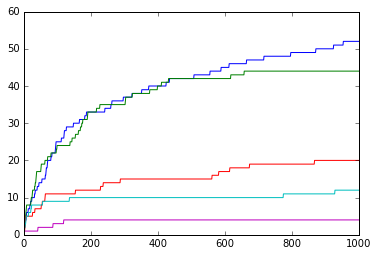

In [48]:
plt.plot(crp(1000, 15))
plt.plot(crp(1000, 10))
plt.plot(crp(1000, 5))
plt.plot(crp(1000, 2))
plt.plot(crp(1000, 1))

### 2 DP

In [323]:
def G_0(theta, i):
    if theta[i] <= 3/4 and theta[i+1] <= 3/4:
        G_0 = (4/3 * theta[i] + 4/3 * theta[i+1])*(theta[i+1] - theta[i])*0.5
    elif theta[i] <= 3/4 and theta[i+1] > 3/4:
        G_0 = (4/3 * theta[i] + 1)*(1-theta[i])*0.5 + (1 + -4/5*(theta[i+1] - 2))*(theta[i+1] - 1)*0.5
    else:
        G_0 = (-4/5*(theta[i] - 2)  + -4/5*(theta[i+1] - 2) )*(theta[i+1] - theta[i])*0.5 
    return G_0

In [324]:
def  G(alpha, theta):
    G = np.random.dirichlet(np.array([alpha*G_0(theta, i) for i in range(len(theta)-1)]))
    return G

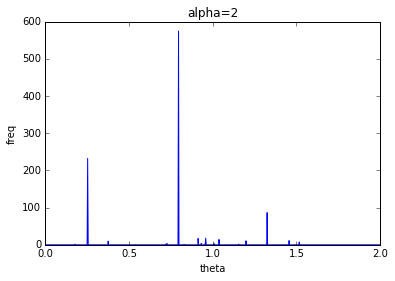

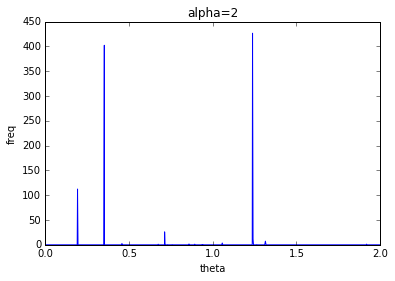

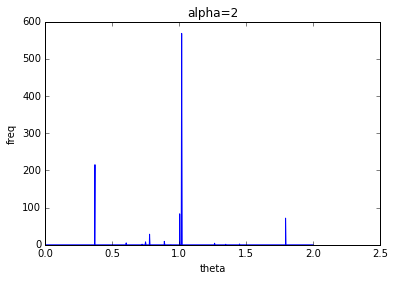

In [353]:
alpha = 2

for i in range(3):
    T = np.array([np.random.uniform()*2 for i in range(1000)])
    theta = np.cumsum(T*2/T.sum())
    g = G(alpha, theta)
    plt.plot(theta, np.append(g, 0)*1000)
    plt.title("alpha=2")
    plt.xlabel("theta")
    plt.ylabel("freq")
    plt.show()

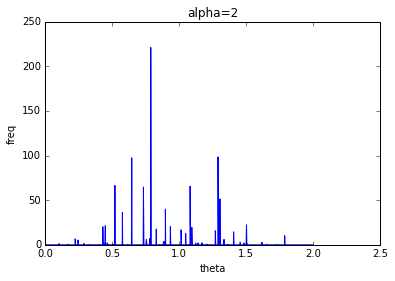

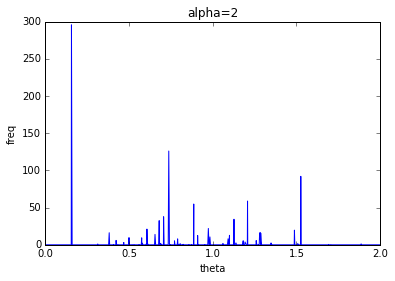

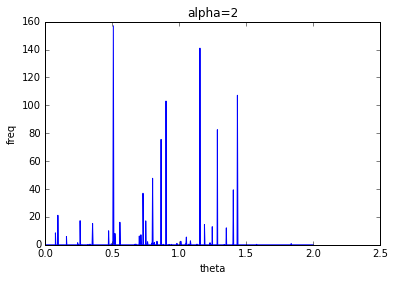

In [354]:
alpha = 10

for i in range(3):
    T = np.array([np.random.uniform()*2 for i in range(1000)])
    theta = np.cumsum(T*2/T.sum())
    g = G(alpha, theta)
    plt.plot(theta, np.append(g, 0)*1000)
    plt.title("alpha=2")
    plt.xlabel("theta")
    plt.ylabel("freq")
    plt.show()